**BANK CUSTOMER SEGEMENTATION**

Most banks have a large customer base - with different characteristics in terms of age, income,
values, lifestyle, and more. Customer segmentation is the process of dividing a customer dataset into
specific groups based on shared traits.

In [1]:
#laoding all the necessary Libraries required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading the dataset
df=pd.read_csv('/content/bank_transactions.csv', encoding='latin-1')
# df=df.iloc[:85000,:]
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


**Exploratory Data Analysis**

In [3]:
#check for shape and shape
print(df.shape)
print(df.size)

(1048567, 9)
9437103


In [4]:
df.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)'],
      dtype='object')

In [5]:
# information check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


We can observe that many numerical columns are label as object Datatype we must fix this later .

In [6]:
# check for descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustAccountBalance,1046198.0,115403.540056,846485.380601,0.0,4721.76,16792.18,57657.36,1.150355e+08
TransactionTime,1048567.0,157087.529393,51261.854022,0.0,124030.00,164226.00,200010.00,2.359590e+05
TransactionAmount (INR),1048567.0,1574.335003,6574.742978,0.0,161.00,459.03,1200.00,1.560035e+06


We found that there is high scale difference Between our Transaction Dataset ,this must be scaled.

In [7]:
#check for null values
df.isnull().sum()

,0
TransactionID,0
CustomerID,0
CustomerDOB,3397
CustGender,1100
CustLocation,151
CustAccountBalance,2369
TransactionDate,0
TransactionTime,0
TransactionAmount (INR),0


Since the number of null values are very less compared to size of dataset We will be dropping the null values from these columns ( like 'CustomerDOB',
 'CustGender',  'CustLocation',  'CustAccountBalance').

**Data cleaning**

In [8]:
# Dropping rows null values from the columns(like 'CustomerDOB',
# 'CustGender', 'CustLocation', 'CustAccountBalance')where important values are missing.
df.dropna(subset=['CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance','TransactionAmount (INR)'],inplace=True)
print("\nMissing values after cleaning:\n", df.isnull().sum().sum())


Missing values after cleaning:
 0


**Feature Engieering**

In [9]:
#Earlier we found that CustomerDOB is of object type , so we must convert
# it into Datetime object
from datetime import datetime

df['CustomerDOB']=pd.to_datetime(df['CustomerDOB'],errors='coerce')

# obtaining the current age of customer
df['Age']=datetime.now().year - df['CustomerDOB'].dt.year

In [10]:
#aggregate transaction data per customer
df = df.groupby('CustomerID').agg({
    'Age':'mean',
    'CustGender':'first',
    'CustLocation':'first',
    'CustAccountBalance':'mean',
    'TransactionAmount (INR)':['sum','mean','count'],

}).reset_index()

In [11]:
# flattening multindex columns
df.columns=['CustomerID','Age','Gender','Location','CustAccountBalance','TotalTransactionAmount','AvgTransactionAmount','TransactionCount']

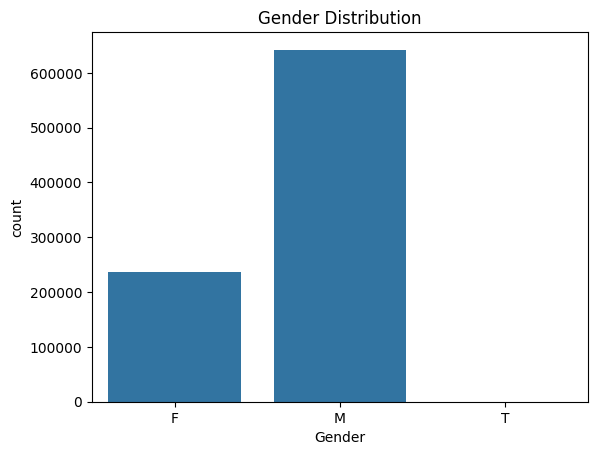

In [12]:
# Gender distribution
sns.countplot(data=df, x='Gender')
plt.title('Gender Distribution')
plt.show()

Gender Distribution: Majority of the customers are male, indicating a gender imbalance in the customer base

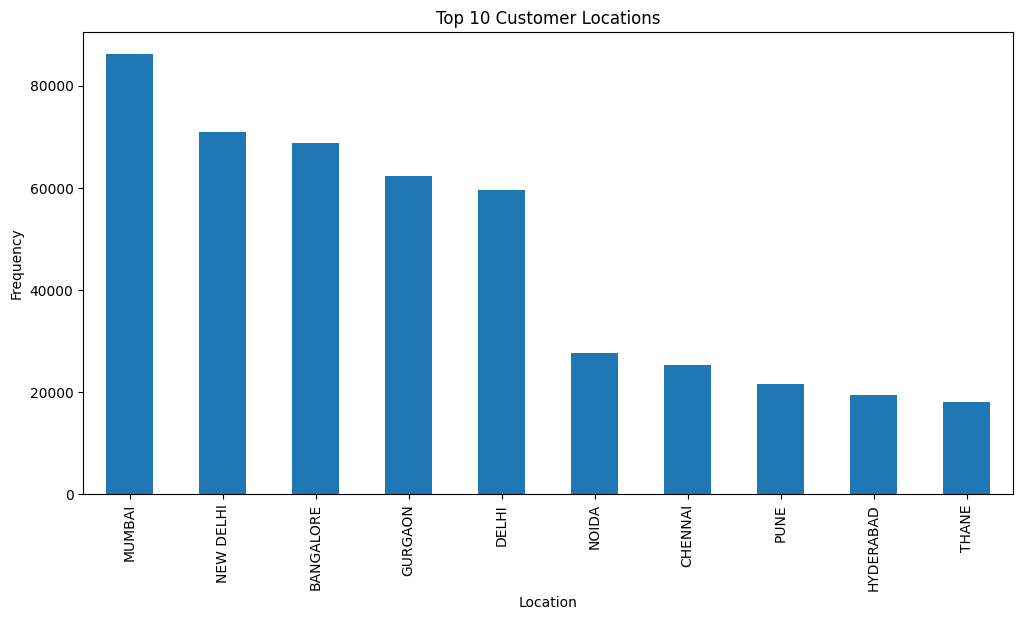

In [13]:
# Customer location frequency
plt.figure(figsize=(12,6))
df['Location'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Customer Locations')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.show()

Top 10 Locations: Most customers are concentrated in major metropolitan cities, with Mumbai leading the list.

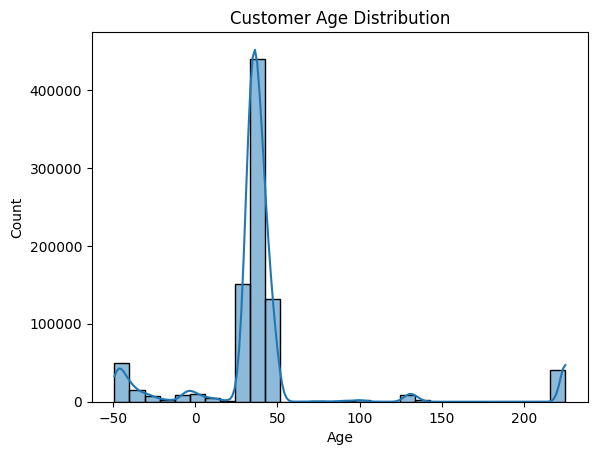

In [14]:
# Age distribution
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Customer Age Distribution')
plt.show()


Age Distribution: Most customers are aged between 30-40, but data contains outliers like negative and unrealistic ages.

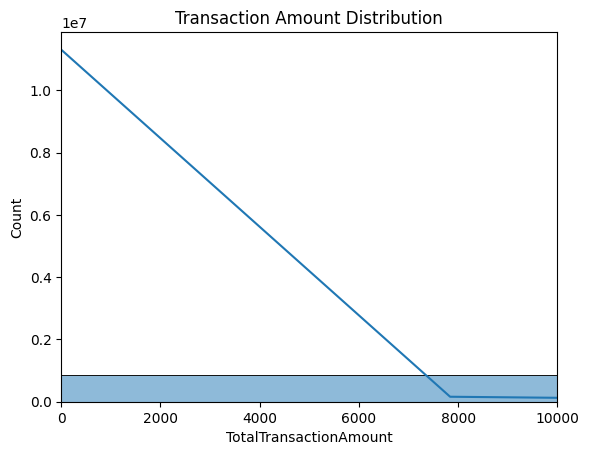

In [15]:
# Transaction Amount
sns.histplot(df['TotalTransactionAmount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlim(0, 10000)  # clip to remove extreme outliers for clarity
plt.show()

Transaction Amount Distribution: Most transactions are of lower amounts, with frequency dropping sharply as the amount increases.

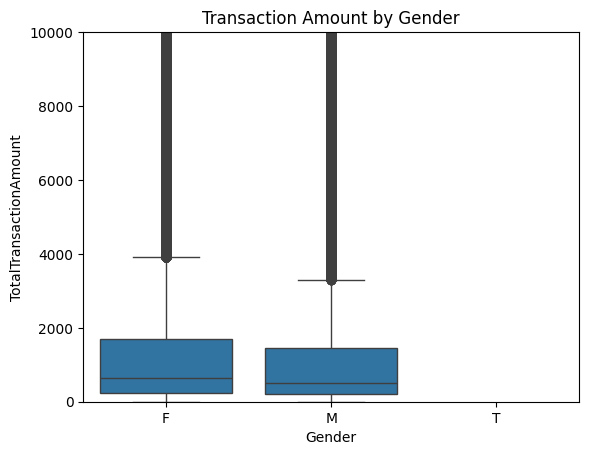

In [16]:
# Transaction Amount by Gender
sns.boxplot(data=df, x='Gender', y='TotalTransactionAmount')
plt.title('Transaction Amount by Gender')
plt.ylim(0, 10000)  # trim for visibility
plt.show()


Transaction Amount by Gender: Both males and females show similar transaction patterns, but females exhibit slightly higher median transaction values.

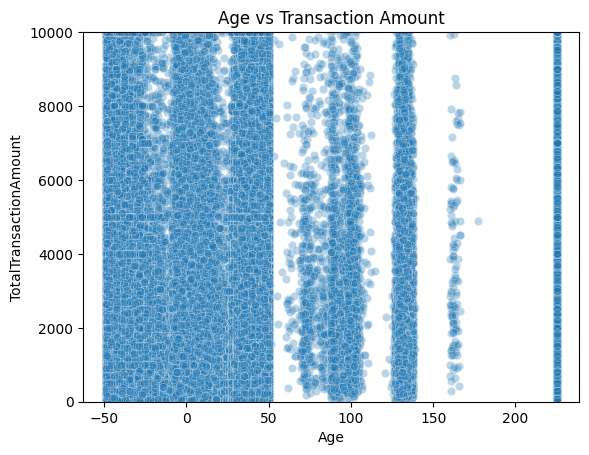

In [17]:
# Age vs Transaction Amount
sns.scatterplot(data=df, x='Age', y='TotalTransactionAmount', alpha=0.3)
plt.title('Age vs Transaction Amount')
plt.ylim(0, 10000)
plt.show()

Age vs Transaction Amount: Majority of transactions cluster around realistic ages (20–50), though extreme and invalid ages suggest data quality issues.

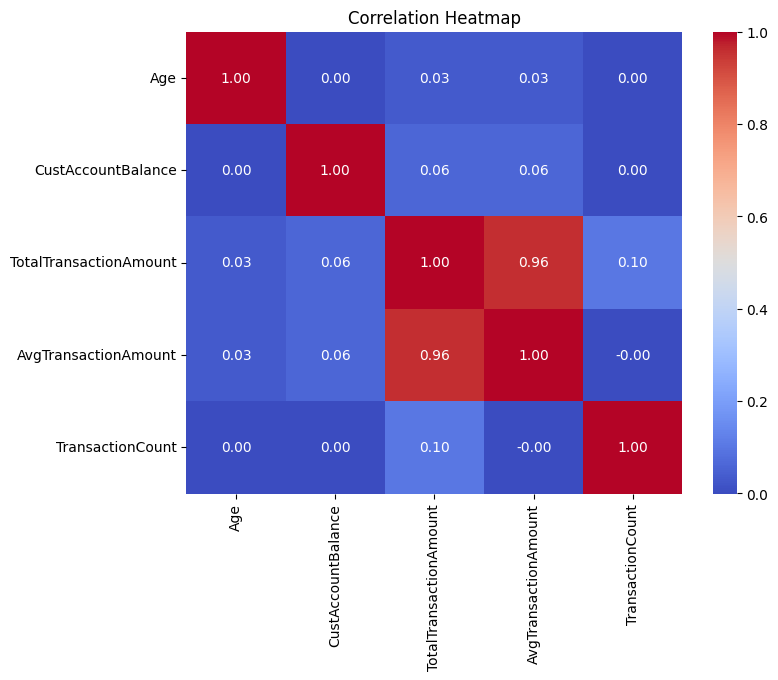

In [18]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

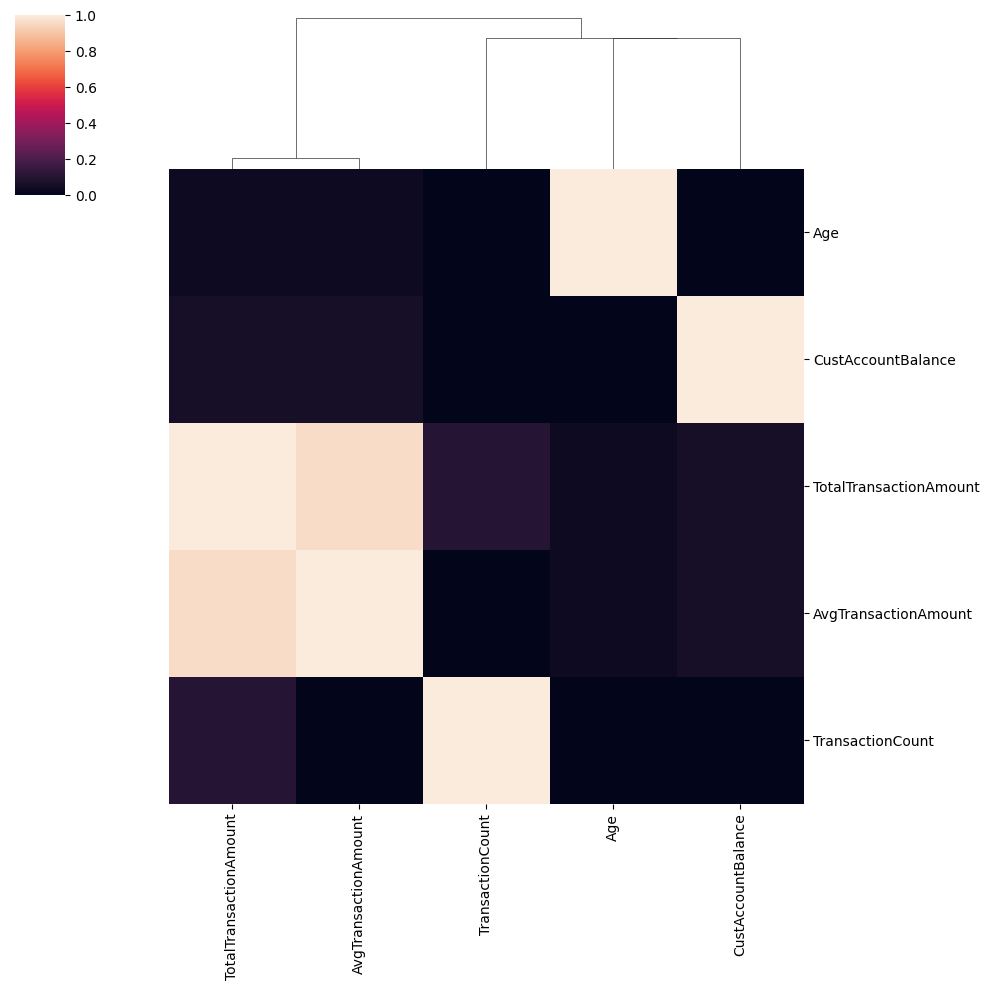

In [19]:
sns.clustermap(df.corr(numeric_only=True),row_cluster=False)
plt.show()

In [20]:
df.head()

,CustomerID,Age,Gender,Location,CustAccountBalance,TotalTransactionAmount,AvgTransactionAmount,TransactionCount
0,C1010011,37.5,F,NOIDA,76340.635,5106.0,2553.0,2
1,C1010012,31.0,M,MUMBAI,24204.490,1499.0,1499.0,1
2,C1010014,37.0,F,MUMBAI,100112.950,1455.0,727.5,2
3,C1010018,35.0,F,CHAMPARAN,496.180,30.0,30.0,1
4,C1010024,-40.0,M,KOLKATA,87058.650,5000.0,5000.0,1


In [21]:
#one Hot encoding
df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})

# initialisng the encoder
encoder=LabelEncoder()
df['Location']=encoder.fit_transform(df['Location'])

In [22]:
ruk jaa ek dil diwane puch toh bta aaa

SyntaxError: invalid syntax (<ipython-input-22-06953d920a7e>, line 1)

# **Feature Scaling**

In [23]:
# selecting the feature
feature=['Age', 'CustAccountBalance',
       'TotalTransactionAmount', 'AvgTransactionAmount', 'TransactionCount']

# Sample from the original DataFrame
sampled_df = df.sample(n=10000, random_state=101)

# intialising the scaler
scaler=StandardScaler()
scaled_feature=scaler.fit_transform(sampled_df[feature])
scaled_feature

array([[-0.09648901, -0.08522544,  0.1778916 , -0.01742204,  1.87920725],
       [ 0.05570746, -0.10894606, -0.23881017, -0.21832447, -0.40999637],
       [-0.16751402, -0.11264447, -0.29258344, -0.27876154, -0.40999637],
       ...,
       [-0.11678187, -0.11494184, -0.26199681, -0.2646226 ,  1.87920725],
       [-0.10663544, -0.11868509,  0.35976696,  0.45443069, -0.40999637],
       [ 0.0354146 , -0.07589494, -0.24045461, -0.2201727 , -0.40999637]])

# **PCA**

In [25]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch


# PCA (retain 95% of variance)
pca=PCA(n_components=2)
pca_feature=pca.fit_transform(scaled_feature)
sampled_df['PCA1']=pca_feature[:,0]
sampled_df['PCA2']=pca_feature[:,1]
# df['PCA1']

# **KMeans**

In [28]:
# Kmeans clustering


# will use this same sampled df for entire ML models

kmeans=KMeans(n_clusters=4,random_state=101)
sampled_df['KMeans_cluster']=kmeans.fit_predict(scaled_feature)

kmeans_score=silhouette_score(scaled_feature,sampled_df['KMeans_cluster'])
print(f"KMeans Silhouette score :{kmeans_score:.4f}")

KMeans Silhouette score :0.5531


# **Hierarchical Clustering**

In [30]:
hierarchical = AgglomerativeClustering(n_clusters=4)
sampled_df['Hierarchical_clustering']=hierarchical.fit_predict(scaled_feature)

hierarchical_score=silhouette_score(scaled_feature,sampled_df['Hierarchical_clustering'])
print(f"Hierarchical Silhouette score :{hierarchical_score:.4f}")

Hierarchical Silhouette score :0.7128


# **Gaussian Mixture Model(GMM) Clustering**

In [33]:
from sklearn.mixture import GaussianMixture
gmm=GaussianMixture(n_components=4,random_state=42)
sampled_df['gmm_cluster']=gmm.fit_predict(scaled_feature)


Gaussian_score=silhouette_score(scaled_feature,sampled_df['gmm_cluster'])
print(f"Gaussian Silhouette score :{hierarchical_score:.4f}")

Gaussian Silhouette score :0.7128


# **Visualising cluster with PCA**

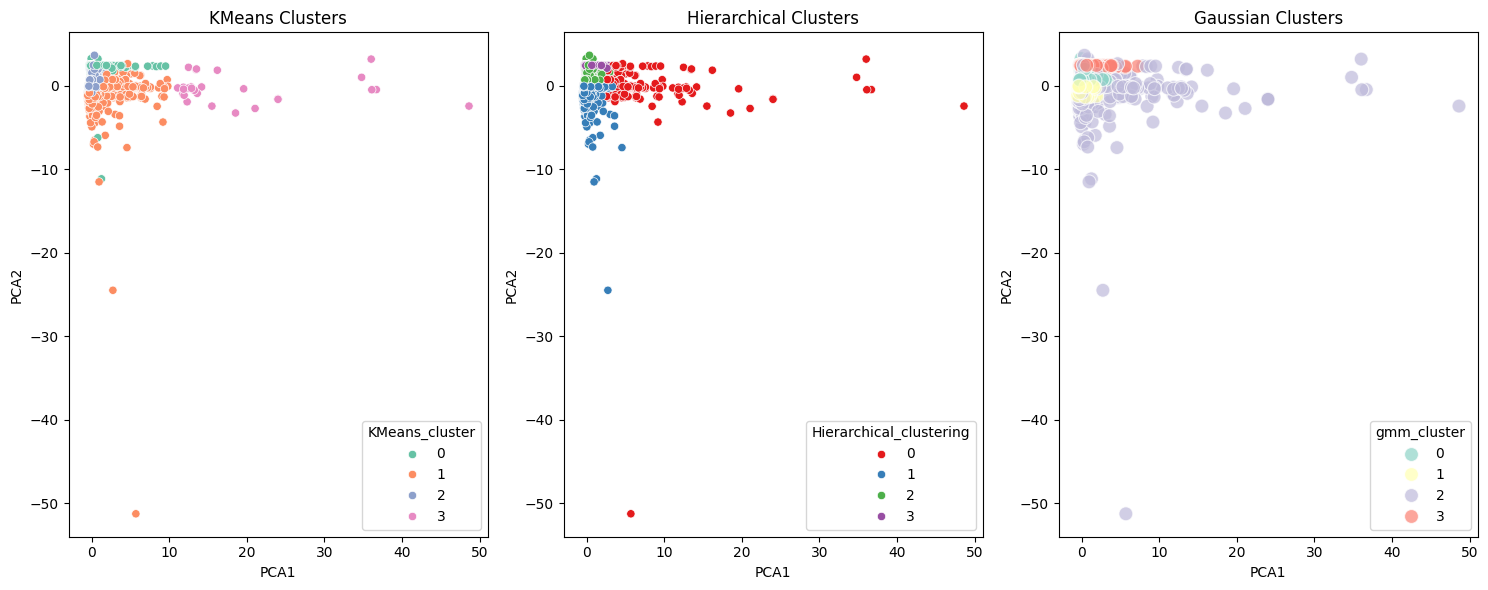

In [35]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(data=sampled_df, x='PCA1', y='PCA2', hue='KMeans_cluster', palette='Set2')
plt.title('KMeans Clusters')

plt.subplot(1, 3, 2)
sns.scatterplot(data=sampled_df, x='PCA1', y='PCA2', hue='Hierarchical_clustering', palette='Set1')
plt.title('Hierarchical Clusters')

plt.subplot(1, 3, 3)
sns.scatterplot(data=sampled_df, x='PCA1', y='PCA2', hue='gmm_cluster', palette='Set3',s=100,
    alpha=0.7)
plt.title('Gaussian Clusters')

plt.tight_layout()
plt.show()

# **DBSCAN**

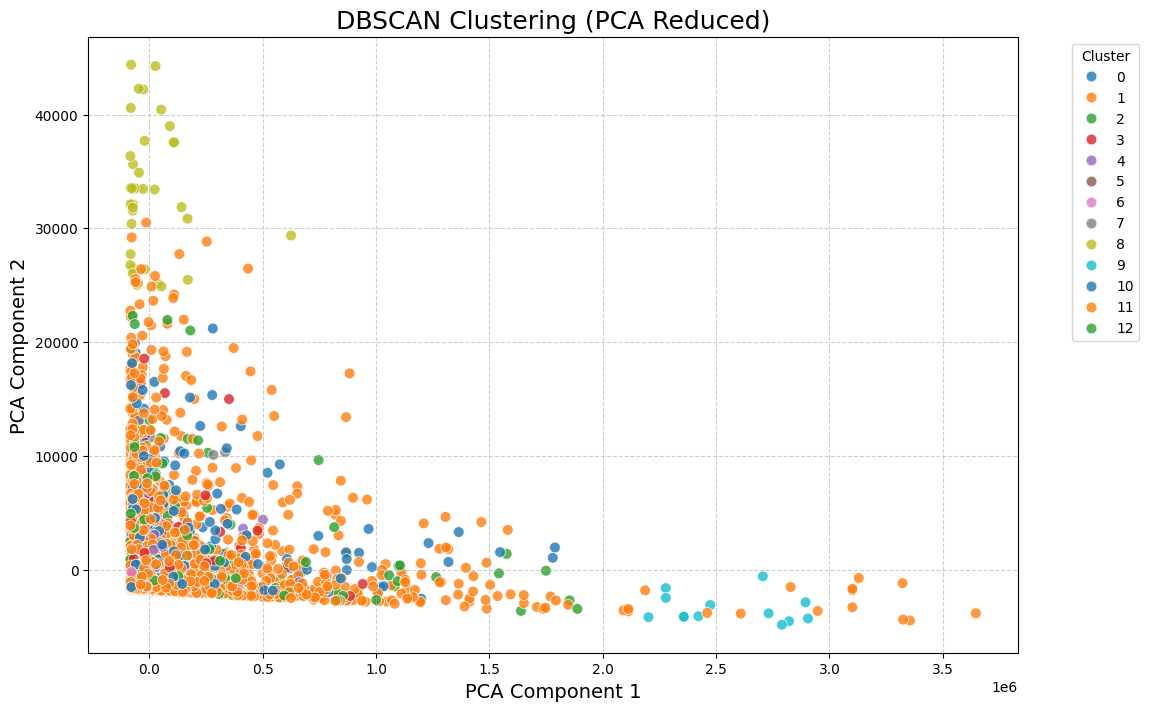

In [31]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
sampled_df['DBSCAN_cluster'] = dbscan.fit_predict(scaled_feature)

# Silhouette Score only for non-noise clusters
filtered_dbscan = sampled_df[sampled_df['DBSCAN_cluster'] != -1]


# Visualization with noise points colored separately

# PCA to 2 components for visualization
pca_vis = PCA(n_components=2)
reduced_data_vis = pca_vis.fit_transform(filtered_dbscan[feature])

filtered_dbscan['PCA1'] = reduced_data_vis[:, 0]
filtered_dbscan['PCA2'] = reduced_data_vis[:, 1]

plt.figure(figsize=(12, 8))

# Plot non-noise points
sns.scatterplot(
    data=filtered_dbscan[filtered_dbscan['DBSCAN_cluster'] != -1],
    x='PCA1',
    y='PCA2',
    hue='DBSCAN_cluster',
    palette='tab10',
    s=60,
    alpha=0.8,
    legend='full'
)

# Plot noise points separately
sns.scatterplot(
    data=filtered_dbscan[filtered_dbscan['DBSCAN_cluster'] == -1],
    x='PCA1',
    y='PCA2',
    color='gray',
    s=40,
    alpha=0.5,
    label='Noise'
)

plt.title('DBSCAN Clustering (PCA Reduced)', fontsize=18)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
